# importing

In [9]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import emcee

In [10]:
import lmfit as lf

# setup

In [23]:
def watervisc(temp, a, b):
    return(a/(temp-b))

In [24]:
water_model = lf.Model(watervisc)

# testing
## importing data manually for test fits

In [25]:
wv_data = np.array([0.329, 0.311, 0.299, 0.261, 0.252])/1000
wv_weights = (np.array([0.001,0.002,0.003,0.001,0.002])/1000)**-2
temps = np.array([20,25,30,40,50])+273.15
print(wv_data, wv_weights, temps)

[0.000329 0.000311 0.000299 0.000261 0.000252] [1.00000000e+12 2.50000000e+11 1.11111111e+11 1.00000000e+12
 2.50000000e+11] [293.15 298.15 303.15 313.15 323.15]


In [26]:
params = water_model.make_params(a=-1, b=0.001)
params

name,value,initial value,min,max,vary
a,-1.00000000,None,-inf,inf,True
b,1.0000e-03,None,-inf,inf,True


In [27]:
result = water_model.fit(wv_data, params, weights = wv_weights, temp=temps)
result

# importing water data
from same source as Zgorski thesis: values and uncertainties were read directly off of plot:
I really only needed the best-fit line so these aren't *perfect*... I was just reading them
by eye off of the plot

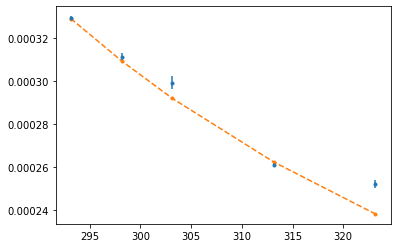

In [28]:
plt.errorbar(x = temps, y = wv_data, yerr = wv_weights**(-1/2),
             marker='.', ls='')
plt.plot(temps, result.best_fit,'.--')

In [9]:
result

In [10]:
print('water viscosity in GODDAMN SI UNITS at 311 K is\n',
    result.eval(temp=311),'\n±',result.eval_uncertainty(temp=311)[0]
)

wv311 = result.eval(temp=311)
wv311sig = result.eval_uncertainty(temp=311)[0]

water viscosity in GODDAMN SI UNITS at 311 K is
 0.0002700469960938935 
± 3.3960553896356527e-06


In [11]:
def etatot(box_height, membrane_thickness, delta, water_visc, 
           membrane_bulk_visc):
    h = membrane_thickness
    H = box_height
    etaw = water_visc
    etamb = membrane_bulk_visc
    return(
        (
            (h+delta)*etamb + (H-h-delta)*etaw
        )
        /H
    )

In [12]:
visc_model = lf.Model(etatot)

In [13]:
print(visc_model.param_names, visc_model.independent_vars)

['membrane_thickness', 'delta', 'water_visc', 'membrane_bulk_visc'] ['box_height']


# importing actual data
honestly, importing this by hand was the easiest. Just 15 values was easy enough,
as I wasn't sure how to do it off the top of my head.

In [14]:
thicknesses = np.array([
    3.791365953109072e-09, 3.793227319062182e-09, 3.789859327217126e-09, 3.789746177370031e-09,
    3.794218144750254e-09, 3.793772680937818e-09, 3.794261977573905e-09, 3.793172273190622e-09,
    3.793691131498471e-09, 3.7992538071065995e-09, 3.8016395939086296e-09, 3.7984365482233506e-09,
    3.799421319796955e-09, 3.799974619289341e-09, 
])

print(np.mean(thicknesses),'\n',
sp.stats.sem(thicknesses))

3.795145776645311e-09 
 1.0379613691951681e-12


The reason the following block divides by the membrane thickness: the original calculation to find viscosity
*multiplied* by thickness ($\eta^{2d}=h\eta^{3d}$). This is accurate to about 1 part in 3000.

In [15]:
heights = np.array([
    np.mean([8.34509, 8.34523, 8.34752, 8.34669, 8.34643]),
    np.mean([13.22519, 13.22604, 13.22597, 13.22885, 13.22690]),
    np.mean([15.34102, 15.33969, 15.33675, 15.33744, 15.33926])
])*1e-9

m_thickness = np.mean(thicknesses)

totalviscs = np.array([7.386920650629981e-12, 5.0145929443229125e-12,
                      4.535046899004862e-12])/m_thickness

visc_uncs = np.array([2.004029051264935e-13, 1.2406123522823227e-13, 
                      1.1092857116781911e-13])/m_thickness

visc_weights = (visc_uncs*np.sqrt(5-1))**-2

print(heights, totalviscs, visc_uncs)

[8.3461920e-09 1.3226590e-08 1.5338832e-08] [0.00194641 0.00132132 0.00119496] [5.28050612e-05 3.26894519e-05 2.92290673e-05]


In [16]:
eta_params = visc_model.make_params(
    membrane_thickness = 3.78e-9,
    delta = 1e-9,
    water_visc = wv311,
    membrane_bulk_visc = wv311*10
)

The following cell, marked with `###HERE` shows the value i was actually manipulating for the fit reruns
in order to find the dependence of the viscosity output on assumed membrane thickness.

Fun fact, if you tell this system that the membrane is 1 meter thick, the shear viscosity only goes up by about a factor of 5, so that's cool.

In [17]:
eta_params['delta'] = lf.Parameter(name = 'delta', min = 0, value = 0,
                                   max = 100, vary=False)
eta_params['water_visc'] = lf.Parameter(name = 'water_visc', min = wv311 - 5*wv311sig,
                                        max = wv311 + 5*wv311sig, value = wv311, vary=False)
eta_params['membrane_thickness'] = lf.Parameter(name = 'membrane_thickness', 
#                                                 value = np.mean(thicknesses), 
                                                value = 4e-9, ###HERE
                                                vary=False)

i'm using emcee (monte carlo maximum likelihood regression) even though it takes slightly longer.
i was convinced that this is the best method (unless i really need speed) by Federica Bianco.

In [18]:
visc_results = visc_model.fit(totalviscs, eta_params,
                              weights = visc_weights,
                              box_height = heights, verbose=True, method='emcee')
print(visc_results.fit_report())

100%|██████████| 1000/1000 [00:14<00:00, 67.85it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.08850891]
[[Model]]
    Model(etatot)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 3
    # variables        = 1
    chi-square         = 13833170.4
    reduced chi-square = 6916585.21
    Akaike info crit   = 48.0319029
    Bayesian info crit = 47.1305152
[[Variables]]
    membrane_thickness:  4e-09 (fixed)
    delta:               0 (fixed)
    water_visc:          0.000270047 (fixed)
    membrane_bulk_visc:  0.00378181 +/- 1.1037e-08 (0.00%) (init = 0.00270047)


In [19]:
visc_results.chisqr

13833170.417985363

Text(0, 0.5, 'total box viscosity\n ($Pa.s=[[\\eta^{3d}]]$)')

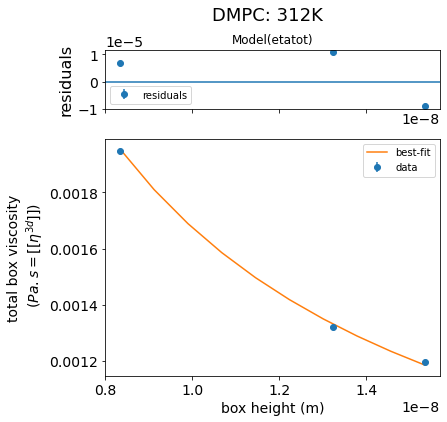

In [30]:
visc_results.plot(numpoints=10)
plt.suptitle('DMPC 312K', size=18)
plt.xlabel('box height (m)', size=14)
plt.ylabel('total box viscosity\n ($Pa.s=[[\eta^{3d}]]$)', size=14)

In [21]:
plotting_thicks = np.array([3e-9, 3.78e-9, 4e-9, 5e-9])
plotting_viscs = np.array([0.00492659, 0.00396724, 0.00376430, 0.00306693])
plotting_shears = plotting_viscs*plotting_thicks

In [22]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.grid'] = False

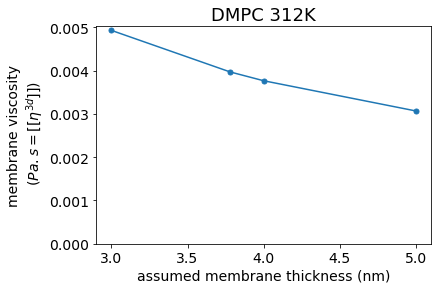

In [32]:
plt.title('DMPC 312K', size=18)
plt.plot(plotting_thicks*1e9, plotting_viscs,'.-',ms=10)
plt.ylim(bottom=0)
plt.xlabel('assumed membrane thickness (nm)', size=14)
plt.ylabel('membrane viscosity\n ($Pa.s=[[\eta^{3d}]]$)', size=14)

plt.show()


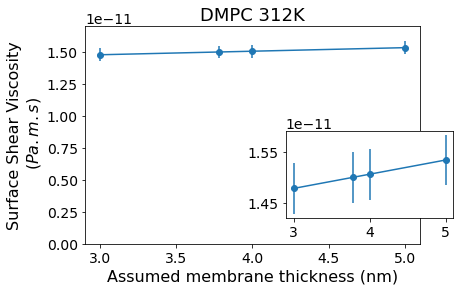

In [103]:
# plt.figure(figsize=(2,4))
fig, ax = plt.subplots()
plt.title('DMPC 312K', size=18)



axins = ax.inset_axes([0.6, 0.12, 0.5, 0.4], xticks=[3,4,5], yticks=[1.45e-11, 1.55e-11])
ax.errorbar(plotting_thicks*1e9, plotting_shears, yerr=4.937009317390438e-13*np.ones(4), marker = '.', ms=12)
axins.errorbar(plotting_thicks*1e9, plotting_shears, yerr=4.937009317390438e-13*np.ones(4), marker = '.', ms=12)

plt.xlabel('Assumed membrane thickness (nm)')
plt.ylabel('Surface Shear Viscosity\n ($Pa.m.s$)')



# plt.ylim(bottom=0)
plt.ylim((0,1.7e-11))
plt.show()

If $\gamma$ is the 2d viscosity (to cut down on subscripts):

$$
\sigma_\gamma =\sqrt{
    \sigma_H^2(\eta_{tot}-\eta_w)^2
    + \sigma_{\eta_{tot}}^2H^2
    + \sigma_h^2\eta_w^2
    + \sigma_{\eta_w}^2(H-h)^2
}
$$

Text(0, 0.5, 'Surface Shear Viscosity\n ($Pa.m.s$)')

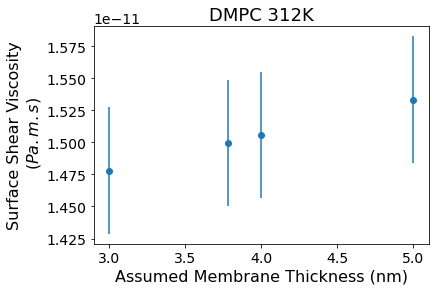

In [34]:
plt.title('DMPC 312K', size=18)
plt.errorbar(plotting_thicks*1e9, plotting_shears, yerr=4.937009317390438e-13*np.ones(4), marker = '.', ms=12, ls='')
plt.xlabel('Assumed Membrane Thickness (nm)')
plt.ylabel('Surface Shear Viscosity\n ($Pa.m.s$)')

# plt.ylim(bottom=0)
# plt.ylim((0,1.7e-11))

In [24]:
print('H = 13e-9 ±', 5e-13)
print('η_T =', 1.5e-3, '±', 3e-5)
print('η_w =', 3e-4, '±', 4.5e-6)
print('h =', 4e-9, '±', 1e-9)

H = 13e-9 ± 5e-13
η_T = 0.0015 ± 3e-05
η_w = 0.0003 ± 4.5e-06
h = 4e-09 ± 1e-09


In [25]:
surface_visc_unc = np.sqrt(
    5e-13**2 * (1.5e-3 - 3e-4)**2
    + 3e-5**2 * 13e-9**2
    + 1e-9**2 * 3e-4**2
    + 4.5e-6**2 * (13e-9 - 4e-9)**2
)
surface_visc_unc

4.937009317390438e-13

In [26]:
4.937009317390438e-13*np.ones(4)

array([4.93700932e-13, 4.93700932e-13, 4.93700932e-13, 4.93700932e-13])